In [1]:
import sys
sys.path.append("../gaia_tools/")
sys.path.append("../scripts/")
from covariance_generation import generate_galactocentric_covmat, transform_cov_cylindirical
import covariance_generation
from mcmc_plots import *
import data_analysis
import transformation_constants
from velocity_curve_plots import load_bin_settings
import helper_functions as helpfunc
import numpy as np
import emcee
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
from pylab import *
from scipy.optimize import curve_fit
from cProfile import label
import pandas as pd
import pickle


In [2]:
def load_galactic_parameters():
   
   # Initial Galactocentric distance
   r_0 = 8277

   # Initial height over Galactic plane
   z_0 = 25

   # Initial solar vector
   v_sun = transformation_constants.V_SUN
   v_sun[0][0] = 11.1
   v_sun[1][0] = 251.5
   v_sun[2][0] = 8.59
   
   return r_0, z_0, v_sun

def apply_initial_cut(icrs_data, run_out_path):

   r_0, z_0, v_sun = load_galactic_parameters()

   galcen_data = data_analysis.get_transformed_data(icrs_data,
                                          include_cylindrical = True,
                                          z_0 = z_0,
                                          r_0 = r_0,
                                          v_sun = v_sun,
                                          debug = True,
                                          is_bayes = True,
                                          is_source_included = True)

   C_icrs = covariance_generation.generate_covmat(icrs_data, is_parallax=True)


   data_array_ICRS =  icrs_data[["ra", "dec","r_est","pmra","pmdec","radial_velocity"]].to_numpy()
   galactocentric_cov = covariance_generation.transform_cov_matrix(C = C_icrs, 
                                        df = data_array_ICRS,
                                        coordinate_system = 'Cartesian',
                                        z_0 = z_0,
                                        r_0 = r_0,
                                        is_bayes = True)

   data_array_crt = galcen_data[["x", "y","r","phi","v_r","v_phi"]].to_numpy()
   cyl_cov = transform_cov_cylindirical(data_array_crt, 
                                                C = galactocentric_cov,
                                                Z_0 = z_0,
                                                R_0 = r_0)
   galcen_data = galcen_data.merge(cyl_cov, on='source_id')

   # Final data cut
   galcen_data = galcen_data[(galcen_data.r < 14000) & (galcen_data.r > 5000)]
   galcen_data = galcen_data[(galcen_data.z < 200) & (galcen_data.z > -200)]

   # Remove halo stars (condition taken from 1806.06038)                        
   v_dif = np.linalg.norm(np.array([galcen_data.v_x, galcen_data.v_y, galcen_data.v_z])-v_sun,
                        axis=0)                                               
   galcen_data['v_dif'] = v_dif                                                 
   galcen_data = galcen_data[galcen_data.v_dif<210.]

   galcen_data.reset_index(inplace=True, drop=True)
   
   return galcen_data

In [5]:
# print('Importing necessary column names...')
# icrs_data_columns = pd.read_csv("/local/sven/gaia_tools_data/gaia_rv_data_bayes.csv", nrows = 10).columns


# print('Importing DR3...')
# dr3_path = '/local/mariacst/2022_v0_project/data/GaiaDR3_RV_RGB_fidelity.csv'
# gaia_dr3 = pd.read_csv(dr3_path)
# icrs_data = gaia_dr3[icrs_data_columns]
# print("Initial size of sample: {}".format(icrs_data.shape))

Importing necessary column names...
Importing DR3...
Initial size of sample: (6586329, 24)


In [3]:
print('Importing DR3...')
#dr3_path = '/local/mariacst/2022_v0_project/data/GaiaDR3_RV_RGB_fidelity.csv'

dr3_path = '/local/mariacst/2022_v0_project/data/GaiaDR3_RV_RGB_fidelity_skinny.csv'
gaia_dr3 = pd.read_csv(dr3_path)

# OLD DISTANCE ESTIMATE
# r_est_error = (gaia_dr3.B_rpgeo - gaia_dr3.b_rpgeo)/2
# gaia_dr3['r_est_error'] = r_est_error

# SWAP FOR GSPPHOT
r_est = gaia_dr3.Dist                                               
gaia_dr3['r_est'] = r_est 
r_est_error = (gaia_dr3.B_Dist - gaia_dr3.b_Dist)/2                 
gaia_dr3['r_est_error'] = r_est_error 


# columns_to_drop = ['Vbroad', 'GRVSmag', 'Gal', 'Teff', 'logg',
#     '[Fe/H]', 'Dist', 'A0', 'RAJ2000', 'DEJ2000', 'e_RAJ2000', 'e_DEJ2000',
#     'RADEcorJ2000', 'B_Teff', 'b_Teff', 'b_logg', 'B_logg', 'b_Dist',
#     'B_Dist', 'b_AG', 'B_AG', 'b_A0', 'B_A0', 'Gmag', 'BPmag', 'RPmag', 'BP-RP']
# gaia_dr3 = gaia_dr3.drop(columns=columns_to_drop)

parallax_over_error = gaia_dr3.parallax/gaia_dr3.parallax_error
gaia_dr3['parallax_over_error'] = parallax_over_error

print(gaia_dr3.columns)


Importing DR3...
Index(['Unnamed: 0', 'Unnamed: 0.1', 'source_id', 'ra', 'dec', 'rgeo',
       'b_rgeo', 'B_rgeo', 'r_est', 'b_rpgeo', 'B_rpgeo', 'ra_error',
       'dec_error', 'parallax', 'parallax_error', 'PM', 'pmra', 'pmra_error',
       'pmdec', 'pmdec_error', 'radial_velocity', 'radial_velocity_error',
       'Dist', 'ra_dec_corr', 'ra_pmdec_corr', 'ra_parallax_corr',
       'ra_pmra_corr', 'b_Dist', 'B_Dist', 'dec_pmra_corr', 'dec_pmdec_corr',
       'dec_parallax_corr', 'parallax_pmdec_corr', 'parallax_pmra_corr',
       'pmra_pmdec_corr', 'r_est_error', 'parallax_over_error'],
      dtype='object')


In [4]:
icrs_data = gaia_dr3

In [5]:
r_0, z_0, v_sun = load_galactic_parameters()

galcen_data = data_analysis.get_transformed_data(icrs_data,
                                        include_cylindrical = True,
                                        z_0 = z_0,
                                        r_0 = r_0,
                                        v_sun = v_sun,
                                        debug = True,
                                        is_bayes = True,
                                        is_source_included = True)

C_icrs = covariance_generation.generate_covmat(icrs_data)


data_array_ICRS =  icrs_data[["ra", "dec","r_est","pmra","pmdec","radial_velocity"]].to_numpy()
galactocentric_cov = covariance_generation.transform_cov_matrix(C = C_icrs, 
                                    df = data_array_ICRS,
                                    coordinate_system = 'Cartesian',
                                    z_0 = z_0,
                                    r_0 = r_0,
                                    is_bayes = True)


Starting galactocentric transformation loop over all data points.. 
Time elapsed for data coordinate transformation: 7.8862514505162835 sec


In [6]:
galactocentric_cov = covariance_generation.generate_galactocentric_covmat(icrs_data, 
                                                               is_bayes = True,
                                                               Z_0 = z_0,
                                                               R_0 = r_0)

In [7]:
cyl_cov = covariance_generation.transform_cov_cylindirical(
                                galcen_data, 
                                galactocentric_cov,
                                Z_0 = z_0,
                                R_0 = r_0)
cyl_cov.shape

(6586329, 3)

In [8]:
galcen_data = galcen_data.merge(cyl_cov, on='source_id')
galcen_data.shape

(6586329, 13)

In [9]:
galcen_data['parallax_over_error'] = icrs_data.parallax_over_error[galcen_data.source_id == icrs_data.source_id]

In [10]:
#galcen_data = galcen_data.merge(cyl_cov, on='source_id')
# Remove noisy distances
galcen_data = galcen_data[galcen_data.parallax_over_error > 20]
print("Galactocentric data shape after removing noisy distances: {}".format(galcen_data.shape))

# Final data cut
galcen_data = galcen_data[(galcen_data.r < 14000) & (galcen_data.r > 5000)]
print("Galactocentric data shape after constraining region in r: {}".format(galcen_data.shape))
galcen_data = galcen_data[(galcen_data.z < 200) & (galcen_data.z > -200)]
print("Galactocentric data shape after constraining region in z: {}".format(galcen_data.shape))


# Remove halo stars (condition taken from 1806.06038)                        
v_dif = np.linalg.norm(np.array([galcen_data.v_x, galcen_data.v_y, galcen_data.v_z])-v_sun,
                    axis=0)                                               
galcen_data['v_dif'] = v_dif                                                 
galcen_data = galcen_data[galcen_data.v_dif<210.]
print("Galactocentric data shape after removing halo stars: {}".format(galcen_data.shape))

galcen_data.reset_index(inplace=True, drop=True)

Galactocentric data shape after removing noisy distances: (1657485, 14)
Galactocentric data shape after constraining region in r: (1648686, 14)
Galactocentric data shape after constraining region in z: (666979, 14)
Galactocentric data shape after removing halo stars: (665663, 15)


In [11]:
galcen_data.shape

(665663, 15)

In [12]:
# Fitting R0, New Binning, 100% Data - GPU -- OLD RESULT
# path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-09-21-42-37_48_full_run'

# 100% Data - GPU -- NEW RESULT FEB
# path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-02-17-12-19-47_48_full_run_mean_no_halo_stars'

# 100% Data - GPU --NEW RESULT MARCH
#path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-03-13-13-35-56_48_full_run_parallax_cut_5'

# 100% Data - GPU --NEW RESULT JUNE - parallax cut 20
path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-06-05-17-01-35_full_run_parallax_cut_20_GSPPhot'

paths=[path1]
labels =[]

samplers=[]
for folder_path in paths:\
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')

# Load run settings and print
bin_setup = load_bin_settings(path1, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

# Load run settings and print
bin_setup = load_bin_settings(path1, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']


1. bin_centers_r= [ 5500.  6500.  7500.  8500.  9500. 10500. 11500. 13000.]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        14000.],
       [ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        14000.]]), array([[-200., -200., -200., -200., -200., -200., -200., -200., -200.],
       [ 200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.]]))
4. nbins= 8
5. V_sun= [[ 11.1 ]
 [251.5 ]
 [  8.59]]
6. R_0= 8277
7. Z_0= 25
8. final_sample_size= (665660, 15)
9. disk_scale= 3000.0
10. vlos_dispersion_scale= 21000.0
11. A_r_info= [(5500.0, 14542206.408749837), (6500.0, 16051176.139629288), (7500.0, 16753211.135520421), (8500.0, 17088750.790579934), (9500.0, 17646741.042022526), (10500.0, 19797712.264007173), (11500.0, 20997304.672734722), (13000.0, 21874473.06439714)]
1. bin_centers_r= [ 5500.  6500.  7500.  8500.  9500. 10500. 11500. 13000.]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 

In [13]:
# Gets V_c mean values and errors
burnin = 2000
path = samplers[0]
reader = emcee.backends.HDFBackend(path, read_only=True)
samples_data = reader.get_chain(discard=burnin)
flatchain = reader.get_chain(flat=True, discard = burnin)

bin_velocities = []
ndim = samples_data.shape[2]

for i in range(ndim):
    mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
    bin_velocities.append((v_mean, v_sub, v_sup))
velocity_array = np.array(bin_velocities)

In [14]:
r_min = 5000/8277
r_max = 14000/8277

# Generate bins
bin_collection = data_analysis.get_collapsed_bins(data = galcen_data,
                                                        theta = 8277,
                                                        BL_r_min = r_min,
                                                        BL_r_max = r_max,
                                                        BL_z_min = -200,
                                                        BL_z_max = 200,
                                                        N_bins = (9, 1),
                                                        r_drift = True,
                                                        debug = False)

bin_collection.merge_bins([-2, -1])

(1.4498006524102935, 1.6914340944786759)
(-200.0, 200.0)


In [15]:
plain_mean_velocities = []
weighted_mean_velocities = []
weighted_var_velocities = []

# Bootstrap errors
for i, bin in enumerate(bin_collection.bins):

    bin.bootstrapped_error = helpfunc.bootstrap_weighted_error(bin.data.v_phi.to_numpy(), bin.data.sig_vphi.to_numpy())

    bin_vphi = bin.data.v_phi.to_numpy()
    bin_sig_vphi = bin.data.sig_vphi.to_numpy()

    weights = 1/bin_sig_vphi
    
    # Weighted mean
    weighted_mean = np.average(bin_vphi, weights=weights)

    weighted_mean_velocities.append(weighted_mean)
    weighted_var_velocities.append(bin.bootstrapped_error)
    plain_mean_velocities.append(np.mean(bin.data.v_phi.to_numpy()))


In [ ]:
# Not Needed - OBSOLETE

A_array = []
for i, bin in enumerate(bin_collection.bins):
    bin.A_parameter = bin.compute_A_parameter(h_r = 3000, 
                                            h_sig = 21000, 
                                            debug=False)
    print(bin.r_boundaries)
    print(bin.A_parameter)
    A_array.append(bin.A_parameter)




In [21]:
# Compute va error #1 - OBSOLETE
r, A = zip(*bin_setup['A_r_info'])
A = np.array(A_array)

va_error_array = []

for i,bin in enumerate(bin_collection.bins):
    v_c = velocity_array[:,0][0:-2][i]
    v_phi = weighted_mean_velocities[i]
    A_i = 2*A[i]

    # add the sub and sup and divide by 2
    vc_error = ((velocity_array[:,1][0:-2][i] + velocity_array[:,2][0:-2][i])/2)
    vphi_error = weighted_var_velocities[i]
    print("vc_error: {}".format(vc_error))
    print("vphi_error: {}".format(np.sqrt(vphi_error)))

    add_1 = -A_i*(v_c + v_phi)**(-2)*vc_error
    add_2 = -A_i*(v_c + v_phi)**(-2)*np.sqrt(vphi_error)

    va_error = np.sqrt(add_1**2 + add_2**2)
    print(va_error)

    va_error_array.append(va_error)

va_error_array = np.array(va_error_array)
va_error_array

vc_error: 4.1735100781562835
vphi_error: 0.3591546954535026
0.0691604016724854
vc_error: 4.305315469665501
vphi_error: 0.31843674576260395
0.06322330889672627
vc_error: 4.369257537075171
vphi_error: 0.40253341726855163
0.0675296827440209
vc_error: 4.366526564713567
vphi_error: 0.4615921682743534
0.07053666795063801
vc_error: 4.398296194863818
vphi_error: 0.3347122773828321
0.07640810995222592
vc_error: 4.194607912990591
vphi_error: 0.3448961850171731
0.07698631619804724
vc_error: 4.298913417338753
vphi_error: 0.3842972340184024
0.07634865271119608
vc_error: 4.128333378666184
vphi_error: 0.48595432840255026
0.07279147355870431
vc_error: 3.9910157359184666
vphi_error: 0.6148868282239125
0.08812560250899364
vc_error: 3.910312257516466
vphi_error: 1.0875013690492918
0.10896360547416137


array([0.0691604 , 0.06322331, 0.06752968, 0.07053667, 0.07640811,
       0.07698632, 0.07634865, 0.07279147, 0.0881256 , 0.10896361])

In [16]:
# Compute va error #2 - NEW

va_error_array = []

for i,bin in enumerate(bin_collection.bins):
    v_c = velocity_array[:,0][0:-2][i]
    # v_phi = weighted_mean_velocities[i]

    v_phi = plain_mean_velocities[i]

    # add the sub and sup and divide by 2
    vc_error = ((velocity_array[:,1][0:-2][i] + velocity_array[:,2][0:-2][i])/2)
    vphi_error = weighted_var_velocities[i]
    print("vc_error: {}".format(vc_error))
    print("vphi_error: {}".format(np.sqrt(vphi_error)))

    va_error = np.sqrt(vc_error**2 + vphi_error**2)
    print(va_error)

    va_error_array.append(va_error)

va_error_array = np.array(va_error_array)
va_error_array

vc_error: 6.1233224487050535
vphi_error: 0.6013656630869626
6.13399231971444
vc_error: 6.4492487320271294
vphi_error: 0.3183790431867176
6.450045280026646
vc_error: 6.6161431439902145
vphi_error: 0.32790455741350655
6.617016771398024
vc_error: 6.586304374218656
vphi_error: 0.3878972366698671
6.5880228297464
vc_error: 6.583231693579776
vphi_error: 0.35002636857373526
6.584371671167623
vc_error: 6.575831681374936
vphi_error: 0.4140673872119986
6.578066434895042
vc_error: 6.189704317920544
vphi_error: 0.733512243740864
6.2130448906079465
vc_error: 6.183309614575393
vphi_error: 1.3006750902205007
6.410565895880874


array([6.13399232, 6.45004528, 6.61701677, 6.58802283, 6.58437167,
       6.57806643, 6.21304489, 6.4105659 ])

# Plotting Section

(array([-5. , -2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

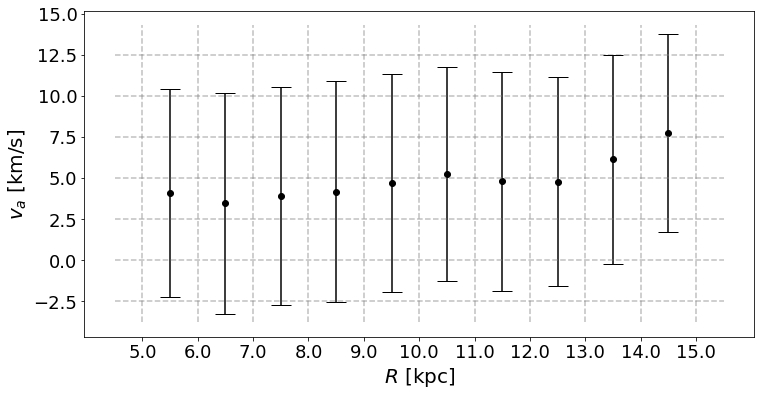

In [13]:
r, A = zip(*bin_setup['A_r_info'])

fig, ax = plt.subplots(figsize=(12, 6))

x = r
y = velocity_array[:,0][0:-3] - np.array(plain_mean_velocities)

ax.scatter(x, -y, color='black')

plt.errorbar(x, -y, 
                    yerr=va_error_array, color='black', linestyle='', capsize=10)

# plt.errorbar(x_values, -y_values,
#                     yerr= y_error,
#                     fmt='o', c=colors[i_path], label=labels[i_path])

def numfmt(x, pos):
            s = '{:.1f}'.format(x / 1000.0)
            return s
fmt = ticker.FuncFormatter(numfmt)
ax.xaxis.set_major_formatter(fmt)

bin_edges_r = bin_setup['bin_edges'][0][0]
bin_edges_z = bin_setup['bin_edges'][1].T[0]

ax.vlines(bin_edges_r, np.min(-(y + va_error_array)) - 0.5, np.max(-(y - va_error_array)) + 0.5, linestyles='dashed', alpha=0.5, colors='grey')
ax.set_xticks(bin_edges_r)

h_lines  = np.linspace(-2.5, 12.5, 7)
ax.hlines(h_lines, 4500, 15500, linestyles='dashed', alpha=0.5, colors='grey')

fontdict = {'fontsize' : 20}

ax.set_xlabel(r'$R$ [kpc]', fontdict= fontdict)
ax.set_ylabel(r'$v_a$ [km/s]', fontdict= fontdict)

plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
#plt.title('Asymmetric Drift Velocity', fontsize=18, pad=12)

#plt.savefig('Asm_Drift_Feb.pdf', dpi = 300, bbox_inches='tight')

[4.12625933 3.46525623 3.92147181 4.19306802 4.7172859  5.25864068
 4.80933608 4.78463867 6.14735506 7.7689684 ]
[6.32959391 6.71286074 6.65441724 6.74634586 6.65527607 6.51080111
 6.65450078 6.35481629 6.35313667 6.03127835]
[10.45585324 10.17811697 10.57588904 10.93941388 11.37256197 11.76944179
 11.46383686 11.13945496 12.50049173 13.80024676]


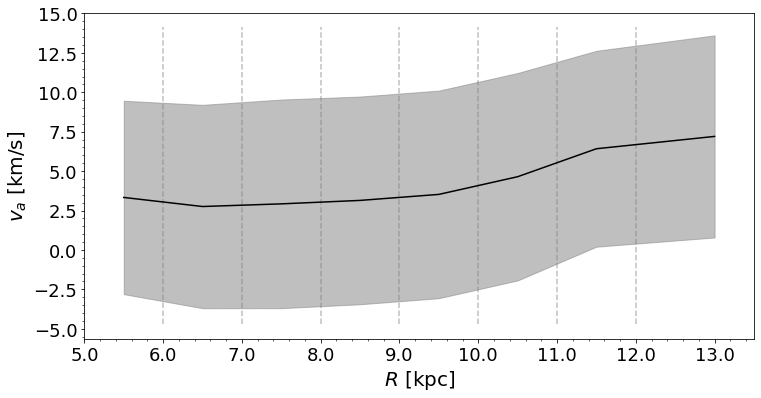

In [19]:
# Shaded region plot
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

r, A = zip(*bin_setup['A_r_info'])

fig, ax = plt.subplots(figsize=(12, 6))

x = r
y = velocity_array[:,0][0:-3] - np.array(plain_mean_velocities)

ax.plot(x, -y, 'k-')
ax.fill_between(x, 
                -y-va_error_array, 
                -y+va_error_array,
                color='gray',
                alpha=0.5
               )

def numfmt(x, pos):
            s = '{:.1f}'.format(x / 1000.0)
            return s
fmt = ticker.FuncFormatter(numfmt)
ax.xaxis.set_major_formatter(fmt)

bin_edges_r = bin_setup['bin_edges'][0][0]
bin_edges_z = bin_setup['bin_edges'][1].T[0]

ax.vlines(bin_edges_r, np.min(-(y + va_error_array)) - 1, np.max(-(y - va_error_array)) + 0.5, linestyles='dashed', alpha=0.5, colors='grey')
ax.set_xticks(bin_edges_r)

h_lines  = np.linspace(-2.5, 22.5, 11)
#ax.hlines(h_lines, 4500, 15500, linestyles='dashed', alpha=0.5, colors='grey')

fontdict = {'fontsize' : 20}

ax.set_xlabel(r'$R$ [kpc]', fontdict= fontdict)
ax.set_ylabel(r'$v_a$ [km/s]', fontdict= fontdict)

ax.xaxis.set_major_locator(MultipleLocator(1e3))
ax.yaxis.set_major_locator(MultipleLocator(2.5))

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.xlim(5e3, 13.5e3)

plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
#plt.title('Asymmetric Drift Velocity', fontsize=18, pad=12)

plt.savefig('Asm_Drift_June_Shaded_8_bins.pdf', dpi = 300, bbox_inches='tight')


In [24]:
print(-y)
print(va_error_array)

[3.33000153 2.75397744 2.92285485 3.14182437 3.52317976 4.64449248
 6.4191187  7.2008747 ]
[6.13399232 6.45004528 6.61701677 6.58802283 6.58437167 6.57806643
 6.21304489 6.4105659 ]


In [25]:
print(-y)
print(va_error_array)

[3.33000153 2.75397744 2.92285485 3.14182437 3.52317976 4.64449248
 6.4191187  7.2008747 ]
[6.13399232 6.45004528 6.61701677 6.58802283 6.58437167 6.57806643
 6.21304489 6.4105659 ]


In [26]:
np.round(-y,1)

array([3.3, 2.8, 2.9, 3.1, 3.5, 4.6, 6.4, 7.2])

In [27]:
np.round(va_error_array, 1)

array([6.1, 6.5, 6.6, 6.6, 6.6, 6.6, 6.2, 6.4])

## Data to file

In [15]:
weighted_mean_velocities = np.array(weighted_mean_velocities)
weighted_var_velocities = np.array(weighted_var_velocities)
r_array = np.array(r)

In [29]:
data_array = np.vstack((r_array, weighted_mean_velocities, weighted_var_velocities))
data_array.T

array([[ 5.50000000e+03, -2.23259169e+02,  1.31411919e-01],
       [ 6.50000000e+03, -2.29734737e+02,  9.81012801e-02],
       [ 7.50000000e+03, -2.32395857e+02,  1.58081018e-01],
       [ 8.50000000e+03, -2.31243153e+02,  2.16960449e-01],
       [ 9.50000000e+03, -2.26940680e+02,  1.17224601e-01],
       [ 1.05000000e+04, -2.25512332e+02,  1.10818350e-01],
       [ 1.15000000e+04, -2.23679947e+02,  1.53632658e-01],
       [ 1.25000000e+04, -2.23182236e+02,  2.37071268e-01],
       [ 1.35000000e+04, -2.18682221e+02,  3.84685506e-01],
       [ 1.45000000e+04, -2.12719768e+02,  1.17155029e+00]])

In [31]:

        

df = pd.DataFrame(data_array.T, columns = ['r','v_phi_wght_mean','boot_error'])
df.to_csv('full_run_rot_vel.csv', index=False)
df



,r,v_phi_wght_mean,boot_error
0,5500.0,-223.259169,0.131412
1,6500.0,-229.734737,0.098101
2,7500.0,-232.395857,0.158081
3,8500.0,-231.243153,0.216960
4,9500.0,-226.940680,0.117225
5,10500.0,-225.512332,0.110818
6,11500.0,-223.679947,0.153633
7,12500.0,-223.182236,0.237071
8,13500.0,-218.682221,0.384686
9,14500.0,-212.719768,1.171550


# Linear Regression of Velocity Curve

In [38]:
velocity_array[0:-3][:,0]

array([-221.25584244, -231.03676565, -234.58135909, -232.74264738,
       -229.84033279, -231.22591656, -230.60639242, -227.52642585])

In [41]:
r

(5500.0, 6500.0, 7500.0, 8500.0, 9500.0, 10500.0, 11500.0, 13000.0)

In [39]:
from scipy.stats import linregress
linear_reg_result = linregress(np.array(r), np.abs(velocity_array[0:-3][:,0]))
linear_reg_result

LinregressResult(slope=0.0002892472029304299, intercept=227.23065749620602, rvalue=0.18326612688084049, pvalue=0.6639925655968644, stderr=0.000633421559454957)

In [40]:
linear_reg_result[0]*1e3

0.28924720293042994

In [36]:
linear_reg_result[-1]*1e3

0.6334215594549569

In [33]:
linear_reg_result[0]*8277 + linear_reg_result[1]

229.6247565948612

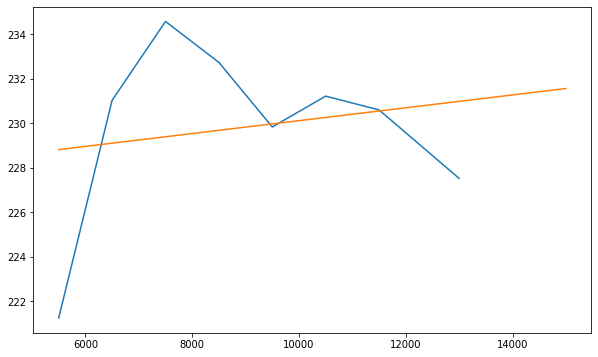

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(r, np.abs(velocity_array[0:-3][:,0]))

x_r_range = np.linspace(5500, 15000, 10)
y_lin_reg = linear_reg_result[0]*x_r_range + linear_reg_result[1]
x_r_range
plt.plot(x_r_range, y_lin_reg)

In [42]:
from scipy.stats import linregress
linear_reg_result = linregress(np.array(r), np.abs(y))
linear_reg_result

LinregressResult(slope=0.0005897681039016363, intercept=-1.1027329635326755, rvalue=0.8879240532881588, pvalue=0.0032302651896341053, stderr=0.00012473211972975694)

In [43]:
linear_reg_result[0]*1e3

0.5897681039016363

In [44]:
linear_reg_result[-1]*1e3

0.12473211972975694

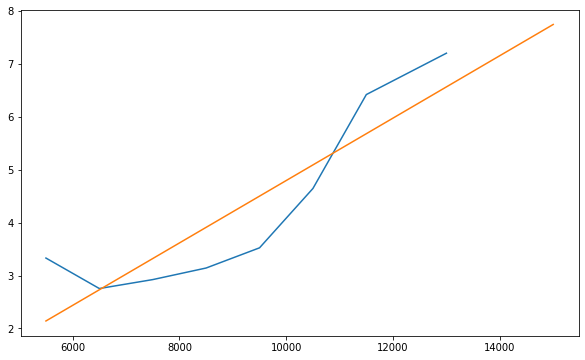

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(r, np.abs(y))

x_r_range = np.linspace(5500, 15000, 10)
y_lin_reg = linear_reg_result[0]*x_r_range + linear_reg_result[1]
x_r_range
plt.plot(x_r_range, y_lin_reg)